In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3","/gpu:4"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-24 19:51:22.112007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 19:51:22.124568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 19:51:22.137046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 19:51:22.140823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 19:51:22.151531: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-10-24 19:51:24.117427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0
2024-10-24 19:51:24.118984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-10-24 19:51:24.120394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o',s=5)  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / np.max(centers)

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [0, 1]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 22, 
                transposed_midpoints_corrected[:, :, 1] * 22, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [5]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None, l1_reg=0.001, l2_reg=0.007):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)
        
    
        x_input = layers.Input(shape=self.input_shape)
        
        x = layers.Conv2D(512, kernel_size=19, padding='same', activation='relu')(x_input)
        
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='linear', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/15KElectronHits_CornersAndCenterWithNoise.h5'
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_13_SparsespotsRandomIndex.h5'
# h5_filename ='/home/da886/Final Electron counting project/Images and Labels/30KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


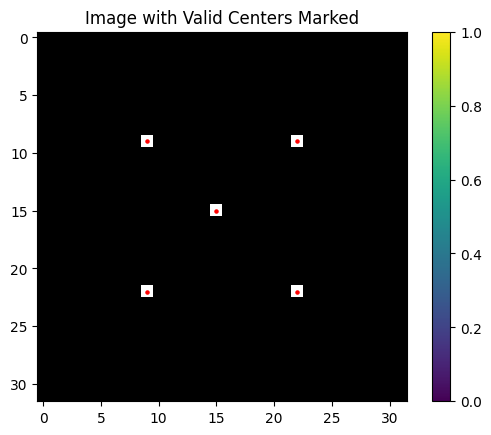

(<matplotlib.image.AxesImage at 0x7f52a4534710>, 10111)

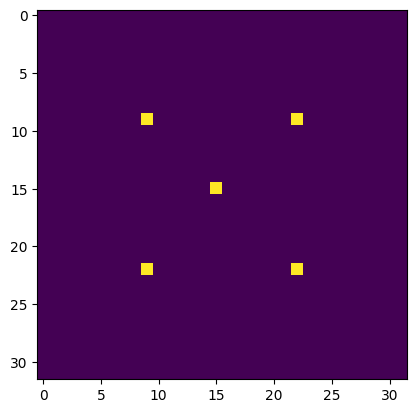

In [7]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l]),l
# plt.grid(True),l

(<matplotlib.image.AxesImage at 0x7f2fb41ad250>, 10273)

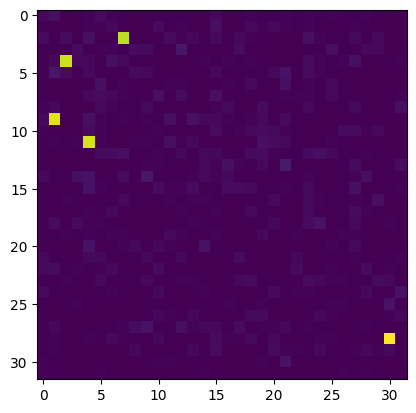

In [8]:
plt.imshow(images[l]),l

In [8]:
t = np.random.randint(0,len(centers))
centers[t]

array([[ 1.,  9.,  9.],
       [ 1., 22.,  9.],
       [ 1.,  9., 22.],
       [ 1., 22., 22.],
       [ 1., 15., 15.]], dtype=float32)

In [9]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [10]:
np.min(train_images), np.max(train_images), np.min(train_midpoints), np.max(train_midpoints)

(0.0, 1.0, 0.4090909, 1.0)

In [11]:
np.max(centers)

22.0

In [12]:

batch_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (12000, 32, 32), Train Midpoints: (12000, 1, 5, 2)
Validation Images: (3000, 32, 32), Validation Midpoints: (3000, 1, 5, 2)


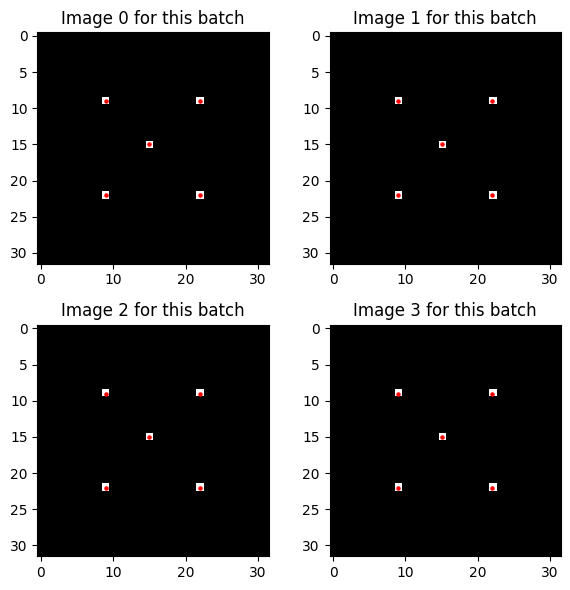

In [13]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [14]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=5e-6
)


In [15]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    model_builder = ModelBuilder()

    model_builder.build_model()

    model_builder.model.summary()

    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
  




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 512)    │       185,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 10)             │     5,242,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 5, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,428,234 (20.71 MB)

 Trainable params: 5,428,234 (20.71 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=200,
    callbacks_list=[lr_scheduler]
)


Epoch 1/200


2024-10-24 19:52:22.696251: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-24 19:52:26.766383: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-24 19:52:26.773433: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729799546.838590 3421121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729799546.850092 3421116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729799546.858061 3421123 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729799546.879042 3421121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729799546.879421 3421116 gpu_timer.cc:11

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2045

2024-10-24 19:52:28.453054: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-24 19:52:28.453158: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-24 19:52:28.453236: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1729799548.843271 3421117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729799548.855272 3421118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729799548.856282 3421117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 0.1857 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 2/200


2024-10-24 19:52:29.980700: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0083 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/200


2024-10-24 19:52:32.077690: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0023 - val_loss: 9.2327e-04 - learning_rate: 0.0010
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.5527e-04 - val_loss: 3.4742e-04 - learning_rate: 0.0010
Epoch 5/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7536e-04

2024-10-24 19:52:34.703454: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.6642e-04 - val_loss: 6.4346e-05 - learning_rate: 0.0010
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 3.9889e-05 - val_loss: 1.2861e-05 - learning_rate: 0.0010
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.0838e-05 - val_loss: 3.3472e-07 - learning_rate: 0.0010
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.0676e-06 - val_loss: 1.0257e-06 - learning_rate: 0.0010
Epoch 9/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.2231e-06

2024-10-24 19:52:40.018308: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 1.1757e-06 - val_loss: 8.0480e-07 - learning_rate: 0.0010
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 3.7929e-07 - val_loss: 1.3692e-08 - learning_rate: 0.0010
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.6192e-08 - val_loss: 2.2066e-08 - learning_rate: 0.0010
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.8935e-08 - val_loss: 3.3582e-09 - learning_rate: 0.0010
Epoch 13/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.7342e-09 - val_loss: 3.1653e-09 - learning_rate: 0.0010
Epoch 14/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 2.5552e-09 - val_loss: 6.2683e-10 - learning_rate: 0.0010
Epoch 15/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.0123e-10
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.4988e-10 - val_loss: 1.7842e-10 - learning_rate: 0.0010
Epoch 16/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1

2024-10-24 19:52:50.175526: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.1676e-11 - val_loss: 4.0834e-12 - learning_rate: 9.0000e-04
Epoch 18/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 1.5134e-11 - val_loss: 3.6175e-12 - learning_rate: 9.0000e-04
Epoch 19/200
 1/12 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 3.6858e-12

2024-10-24 19:52:52.910821: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.9414e-12 - val_loss: 1.1328e-11 - learning_rate: 9.0000e-04
Epoch 20/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 6.5559e-12 - val_loss: 2.1104e-12 - learning_rate: 9.0000e-04
Epoch 21/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 9.4539e-13 - val_loss: 2.7955e-12 - learning_rate: 9.0000e-04
Epoch 22/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 1.4050e-12 - val_loss: 1.6434e-12 - learning_rate: 9.0000e-04
Epoch 23/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.0874e-12 - val_loss: 1.8635e-12 - learning_rate: 9.0000e-04
Epoch 24/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.2080e-12 - val_loss: 2.0729e-12 - learning_rate: 9.0000e-04
Epoch 25/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5892e-12
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.5298e-12 - val_loss: 1.2364e-12 - learning_rate: 9.0000e-04
Epoch 26/200
12

2024-10-24 19:53:10.787319: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.2427e-12 - val_loss: 1.4670e-12 - learning_rate: 8.1000e-04
Epoch 34/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 2.3977e-12 - val_loss: 3.0560e-12 - learning_rate: 8.1000e-04
Epoch 35/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.3174e-12
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.3471e-12 - val_loss: 2.8439e-13 - learning_rate: 8.1000e-04
Epoch 36/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.7313e-13 - val_loss: 9.2957e-13 - learning_rate: 7.2900e-04
Epoch 37/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.1042e-12 - val_loss: 9.9210e-13 - learning_rate: 7.2900e-04
Epoch 38/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 2.6499e-12 - val_loss: 2.6961e-11 - learning_rate: 7.2900e-04
Epoch 39/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.0669e-11 - val_loss: 1.5538e-11 - learning_rate: 7.2900e-04
Epoch 40/200
1

2024-10-24 19:53:23.620514: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.4589e-12 - val_loss: 3.0198e-14 - learning_rate: 7.2900e-04
Epoch 44/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.3213e-10 - val_loss: 1.0890e-08 - learning_rate: 7.2900e-04
Epoch 45/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.2306e-08
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 3.2608e-08 - val_loss: 6.8582e-07 - learning_rate: 7.2900e-04
Epoch 46/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 2.9861e-07 - val_loss: 2.4285e-07 - learning_rate: 6.5610e-04
Epoch 47/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.8511e-08 - val_loss: 5.8126e-08 - learning_rate: 6.5610e-04
Epoch 48/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.7304e-08 - val_loss: 1.0874e-09 - learning_rate: 6.5610e-04
Epoch 49/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 6.6911e-09 - val_loss: 1.7940e-08 - learning_rate: 6.5610e-04
Epoch 50/200
1

2024-10-24 19:53:53.991715: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 5.7813e-09 - val_loss: 2.9276e-10 - learning_rate: 5.9049e-04
Epoch 66/200


2024-10-24 19:53:54.754237: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2823e-09 - val_loss: 1.6610e-09 - learning_rate: 5.3144e-04
Epoch 67/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.9955e-10 - val_loss: 4.5537e-10 - learning_rate: 5.3144e-04
Epoch 68/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 1.8102e-10 - val_loss: 8.8285e-14 - learning_rate: 5.3144e-04
Epoch 69/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 3.4727e-11 - val_loss: 6.9212e-11 - learning_rate: 5.3144e-04
Epoch 70/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.4427e-11 - val_loss: 2.9843e-14 - learning_rate: 5.3144e-04
Epoch 71/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2045e-11 - val_loss: 9.5715e-12 - learning_rate: 5.3144e-04
Epoch 72/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 5.9524e-12 - val_loss: 3.9948e-12 - learning_rate: 5.3144e-04
Epoch 73/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 5.9020e-12 - val_loss: 5.0759e-12 - learning_rate: 5.3144e-04
Epoch 74/200
12/12 ━━━━━━

2024-10-24 19:54:24.844242: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.1494e-13 - val_loss: 2.6859e-13 - learning_rate: 4.3047e-04
Epoch 90/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.0615e-13 - val_loss: 7.8186e-13 - learning_rate: 4.3047e-04
Epoch 91/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 7.6440e-13 - val_loss: 1.7435e-13 - learning_rate: 4.3047e-04
Epoch 92/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.2112e-13 - val_loss: 4.8406e-14 - learning_rate: 4.3047e-04
Epoch 93/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.1587e-13 - val_loss: 1.3092e-13 - learning_rate: 4.3047e-04
Epoch 94/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 4.4013e-12 - val_loss: 1.7142e-13 - learning_rate: 4.3047e-04
Epoch 95/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.8173e-12
Epoch 95: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 9.2308e-12 - val_loss: 1.0481e-14 - learning_rate: 4.3047e-04
Epoch 96/200

2024-10-24 19:54:55.525432: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.1469e-13 - val_loss: 0.0000e+00 - learning_rate: 3.4868e-04
Epoch 114/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 6.5738e-13 - val_loss: 0.0000e+00 - learning_rate: 3.4868e-04
Epoch 115/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.3558e-13
Epoch 115: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 4.8959e-13 - val_loss: 0.0000e+00 - learning_rate: 3.4868e-04
Epoch 116/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 2.6111e-13 - val_loss: 0.0000e+00 - learning_rate: 3.1381e-04
Epoch 117/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.1917e-13 - val_loss: 0.0000e+00 - learning_rate: 3.1381e-04
Epoch 118/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 1.2448e-12 - val_loss: 0.0000e+00 - learning_rate: 3.1381e-04
Epoch 119/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.1962e-13 - val_loss: 0.0000e+00 - learning_rate: 3.1381e-04
Epoch

2024-10-24 19:55:19.350251: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.1928e-13 - val_loss: 0.0000e+00 - learning_rate: 2.8243e-04
Epoch 130/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 7.1949e-13 - val_loss: 0.0000e+00 - learning_rate: 2.8243e-04
Epoch 131/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.9697e-13 - val_loss: 0.0000e+00 - learning_rate: 2.8243e-04
Epoch 132/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 9.9563e-13 - val_loss: 0.0000e+00 - learning_rate: 2.8243e-04
Epoch 133/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 3.7991e-13 - val_loss: 0.0000e+00 - learning_rate: 2.8243e-04
Epoch 134/200
 1/12 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 4.3876e-14

2024-10-24 19:55:25.732359: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 9.3182e-13 - val_loss: 0.0000e+00 - learning_rate: 2.8243e-04
Epoch 135/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.3285e-13
Epoch 135: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.9939e-13 - val_loss: 0.0000e+00 - learning_rate: 2.8243e-04
Epoch 136/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.6372e-13 - val_loss: 0.0000e+00 - learning_rate: 2.5419e-04
Epoch 137/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 5.8383e-13 - val_loss: 0.0000e+00 - learning_rate: 2.5419e-04
Epoch 138/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 1.8631e-12 - val_loss: 0.0000e+00 - learning_rate: 2.5419e-04
Epoch 139/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3170e-12 - val_loss: 0.0000e+00 - learning_rate: 2.5419e-04
Epoch 140/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.6850e-12 - val_loss: 0.0000e+00 - learning_rate: 2.5419e-04
Epoch

2024-10-24 19:55:55.908057: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 8.7322e-15 - val_loss: 0.0000e+00 - learning_rate: 2.0589e-04
Epoch 159/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4886e-14 - val_loss: 0.0000e+00 - learning_rate: 2.0589e-04
Epoch 160/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.2977e-14 - val_loss: 0.0000e+00 - learning_rate: 2.0589e-04
Epoch 161/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 1.1412e-13 - val_loss: 0.0000e+00 - learning_rate: 2.0589e-04
Epoch 162/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 2.3466e-13 - val_loss: 0.0000e+00 - learning_rate: 2.0589e-04
Epoch 163/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.5351e-13 - val_loss: 0.0000e+00 - learning_rate: 2.0589e-04
Epoch 164/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.7317e-13 - val_loss: 0.0000e+00 - learning_rate: 2.0589e-04
Epoch 165/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.8990e-13
Epoch 165: ReduceLROnPlateau reducing learning rate to 0.0001853020337

2024-10-24 19:56:26.175767: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 5.0925e-14 - val_loss: 0.0000e+00 - learning_rate: 1.6677e-04
Epoch 180/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 7.3284e-14 - val_loss: 0.0000e+00 - learning_rate: 1.6677e-04
Epoch 181/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.1447e-13 - val_loss: 0.0000e+00 - learning_rate: 1.6677e-04
Epoch 182/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 1.4579e-13 - val_loss: 0.0000e+00 - learning_rate: 1.6677e-04
Epoch 183/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 2.4150e-13 - val_loss: 0.0000e+00 - learning_rate: 1.6677e-04
Epoch 184/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.8288e-14 - val_loss: 0.0000e+00 - learning_rate: 1.6677e-04
Epoch 185/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.0183e-14
Epoch 185: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7092e-14 - val_loss: 0.0000e+00 - learning_rate: 1.6677e-04
Epoch 

2024-10-24 19:56:56.443727: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 8.1262e-14 - val_loss: 0.0000e+00 - learning_rate: 1.3509e-04
Epoch 199/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 1.6320e-13 - val_loss: 0.0000e+00 - learning_rate: 1.3509e-04
Epoch 200/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.6532e-13 - val_loss: 0.0000e+00 - learning_rate: 1.3509e-04


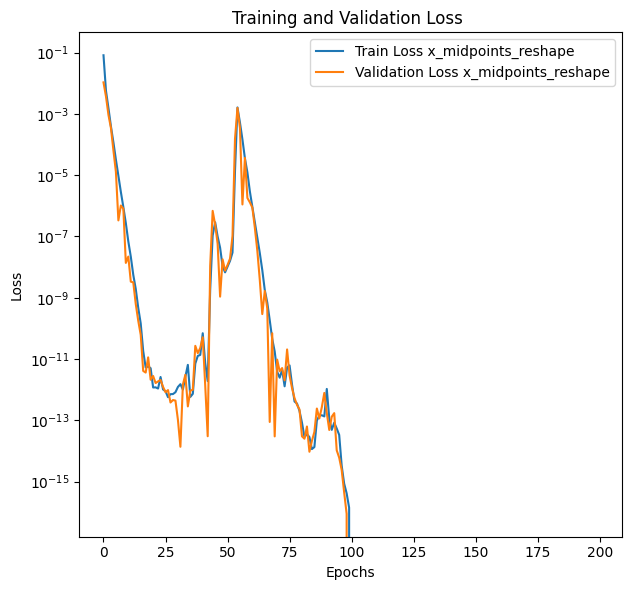

In [17]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
model_builder.model.save("/home/da886/Analysis/Slow Debugging/15KElectronHits_CornersAndCenter.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Define the function for visualizing midpoints
# def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - title: The title of the plot.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title(title)

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Create the validation dataset
# # val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# # val_dataset = val_dataset.batch(800)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# # inputs,targets = next(iter(train_dataset))
# # outputs = model_builder.model.predict(inputs)
# # # Initialize lists to collect the data
# all_images = []
# all_true_midpoints = []
# all_pred_midpoints = []

# # # Loop through each batch in the validation dataset, predict, and collect results
# # for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
#     print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
#     # Get the model predictions
#     predictions =model_builder.model.predict(data_batch)

#     # Extend the lists to store data from each batch
#     all_images.extend(data_batch.numpy())  # Store all images
#     all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
#     all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# # Convert lists to arrays for easier indexing
# all_images = np.array(all_images)
# all_true_midpoints = np.array(all_true_midpoints)
# all_pred_midpoints = np.array(all_pred_midpoints)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints_with_gt(image, true_midpoints, pred_midpoints, title="Predicted vs GT Midpoints"):
    """
    Visualizes ground truth and predicted midpoints on an image and draws lines to connect them.

    Parameters:
    - image: A 3D tensor representing the image.
    - true_midpoints: A 2D tensor representing the ground truth midpoint coordinates (x, y).
    - pred_midpoints: A 2D tensor representing the predicted midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints and lines).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image

    # Ensure that midpoints are in the shape (num_points, 2) for both true and predicted midpoints
    true_midpoints_np = np.reshape(true_midpoints, (-1, 2))
    pred_midpoints_np = np.reshape(pred_midpoints, (-1, 2))

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np, cmap='gray')
    plt.title(title)

    # Plot both ground truth and predicted midpoints
    for i, ((gt_x, gt_y), (pred_x, pred_y)) in enumerate(zip(true_midpoints_np, pred_midpoints_np)):
        if gt_x >= 0 and gt_y >= 0:  # Only plot if the GT point is valid
            plt.scatter(gt_x, gt_y, color='blue', label='Ground Truth' if i == 0 else "", s=30)
            plt.scatter(pred_x, pred_y, color='red', label='Prediction' if i == 0 else "", s=30)

            # Draw a line connecting the GT and predicted points
            plt.plot([gt_x, pred_x], [gt_y, pred_y], color='green', linewidth=1)

    # Add legend only once
    plt.legend()
    plt.show()

# Create the training dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
val_dataset = val_dataset.batch(800)
# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the training dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
for i, (data_batch, midpoints_batch) in enumerate(val_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)


2024-10-24 20:00:07.449283: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1729800007.583678 3421085 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.584669 3421085 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.585351 3421085 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.585984 3421085 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.586831 3421085 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.587486 3421085 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.588189 3421085 gpu_timer

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


W0000 00:00:1729800007.651112 3421114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.652313 3421099 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.656965 3421114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.660675 3421099 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.662423 3421114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.663980 3421099 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800007.664751 3421114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 4, batch shape: (600, 32, 32)
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


W0000 00:00:1729800009.171747 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.172427 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.172983 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.173508 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.174046 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.174585 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.175180 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.175772 3421096 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729800009.176517 3421096 gp

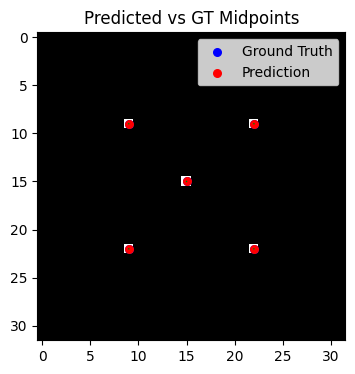

In [20]:
index_to_visualize = np.random.randint(0, len(all_images))
# Visualize the results for the first sample (you can change the index to visualize others)
visualize_midpoints_with_gt(all_images[index_to_visualize ], all_true_midpoints[index_to_visualize ]*np.max(centers), all_pred_midpoints[index_to_visualize ]*np.max(centers))


In [25]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [32]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 32, 32), (9600, 1, 5, 2), (9600, 1, 5, 2))

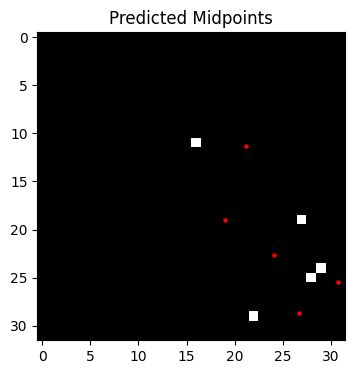

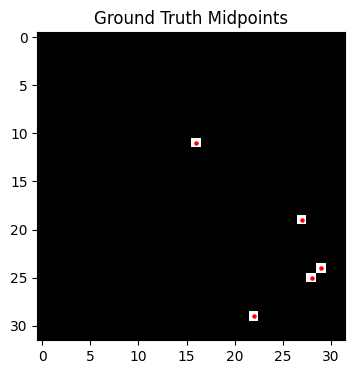

In [23]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Ground Truth Midpoints")


In [38]:
np.min(all_pred_midpoints)*np.max(centers),np.max(all_pred_midpoints)*np.max(centers)

(8.843155e-06, 30.997658)

In [39]:
np.min(all_true_midpoints)*np.max(centers),np.max(all_true_midpoints)*np.max(centers)

(0.0, 31.0)

In [40]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 31.0)

In [41]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[ 4.2590027,  3.908059 ],
         [27.263153 ,  4.3831873],
         [ 5.8743353,  6.6574388],
         [14.020337 ,  8.760142 ],
         [ 4.1754484, 10.7192545],
         [ 4.123699 , 11.2907295],
         [22.326601 , 11.401616 ],
         [ 7.203351 , 12.493043 ],
         [ 5.814977 , 12.613149 ],
         [21.202332 , 14.556165 ],
         [ 8.0557995, 17.444569 ],
         [ 8.055367 , 18.544151 ],
         [ 5.2744675, 26.596989 ]]], dtype=float32),
 array([[[ 4.,  3.],
         [28.,  6.],
         [ 6.,  7.],
         [14.,  9.],
         [ 4., 10.],
         [ 4., 10.],
         [22., 11.],
         [ 7., 12.],
         [ 6., 14.],
         [21., 15.],
         [ 8., 17.],
         [ 8., 18.],
         [ 5., 28.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

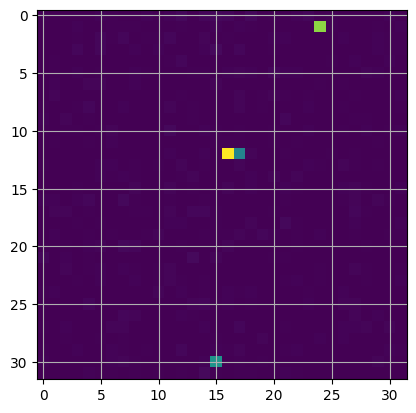

In [44]:
plt.imshow(images[2],)
plt.grid(True)

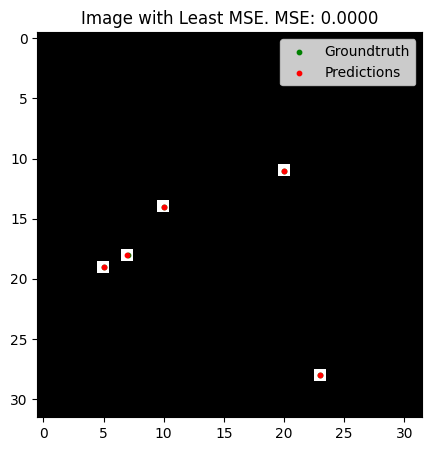

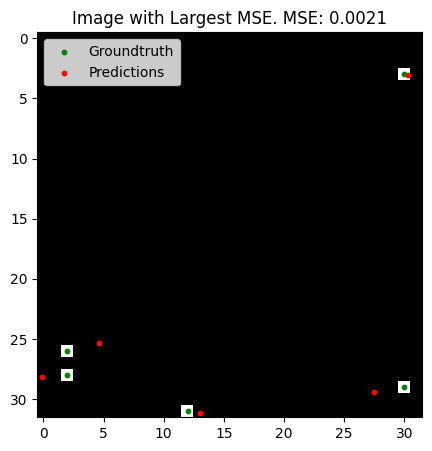

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266